# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.238833165322932

In [8]:
# 18:56

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [10]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0306 - val_loss: -0.0563
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0544 - val_loss: -0.0728
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0669 - val_loss: -0.0821
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0741 - val_loss: -0.0880
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0787 - val_loss: -0.0921
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0823 - val_loss: -0.0956
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0856 - val_loss: -0.0987
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0886 - val_loss: -0.1017
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0914 - val_loss: -0.1049
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0948 - val_los

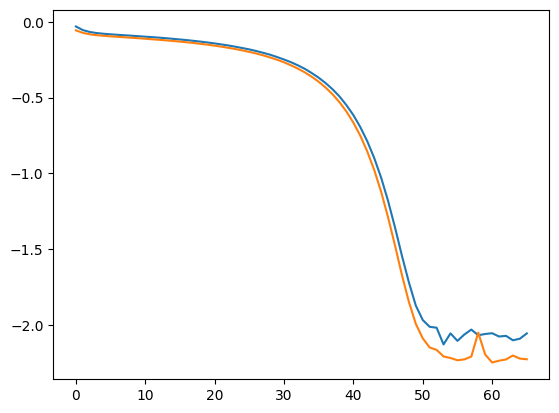

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [14]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 0s 418us/step


In [15]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

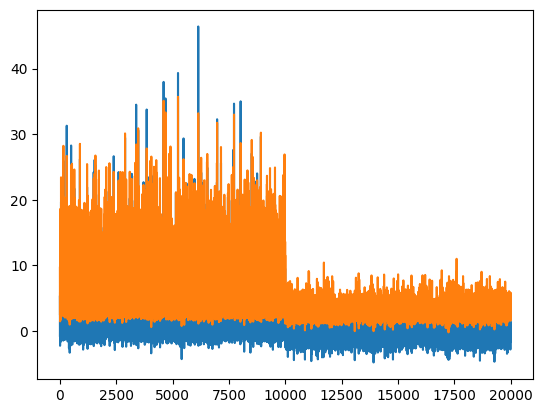

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

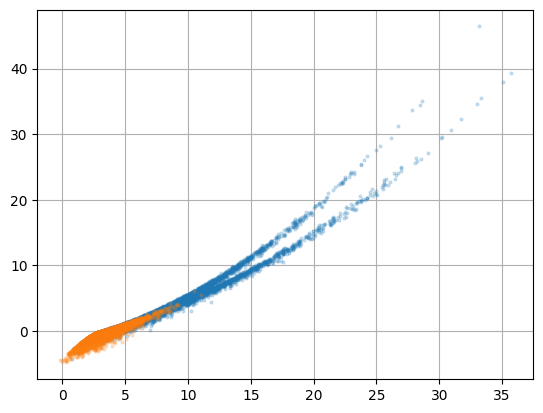

In [17]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

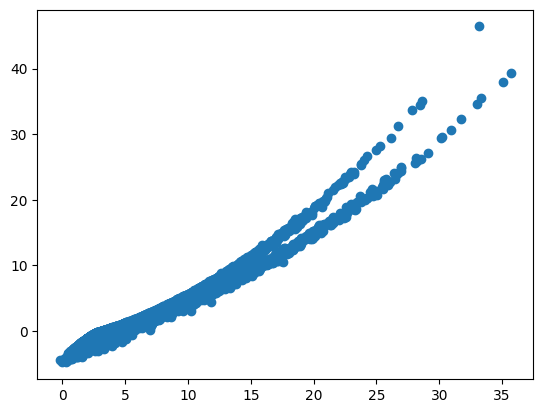

In [18]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [19]:
DV_fun(y, t_x_pred)

2.0694556233653563

In [20]:
DV_fun(y, t_x_opt)

2.238833165322932

In [21]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [22]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 0s 297us/step


In [23]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [24]:
DV_fun(y_new, t_x_pred)

1.8223777289427403

In [25]:
DV_fun(y_new, t_x_opt)

2.220597385212848

### f)

In [26]:
def nwj_loss(y_true, T_x):
    subs_ytrue = tf.subtract(tf.convert_to_tensor(1.0), y_true)

    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(subs_ytrue)
    
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x,y_true)) / n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x),subs_ytrue)) / n2
    kl_div = -(first_term - second_term)
    
    return kl_div

In [27]:
def nwj_fun(y, t):
    return np.mean(t[y==1]) - np.mean(np.exp(t[y==0]-1))

In [28]:
nwj_fun(y, t_x_opt+1)

2.2193695581160413

In [29]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=nwj_loss)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [31]:
hist = model.fit(x_train, y_train, epochs=256, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/256
15/15 [==============================] - 0s 5ms/step - loss: 2.7933 - val_loss: 0.9674
Epoch 2/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9658 - val_loss: 0.9512
Epoch 3/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9540 - val_loss: 0.9408
Epoch 4/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9464 - val_loss: 0.9341
Epoch 5/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9416 - val_loss: 0.9293
Epoch 6/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9379 - val_loss: 0.9265
Epoch 7/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9355 - val_loss: 0.9235
Epoch 8/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9335 - val_loss: 0.9214
Epoch 9/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9316 - val_loss: 0.9195
Epoch 10/256
15/15 [==============================] - 0s 2ms/step - loss: 0.9300 - val_loss: 0.9180
Epoch 11/

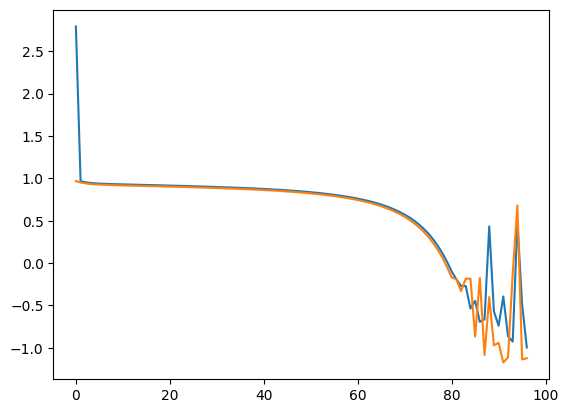

In [32]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [33]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 0s 308us/step


In [34]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2) + 1

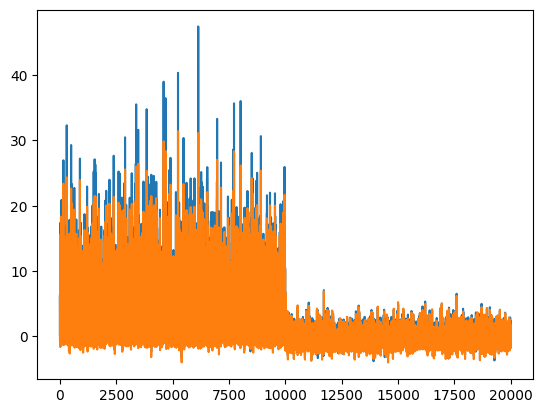

In [35]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

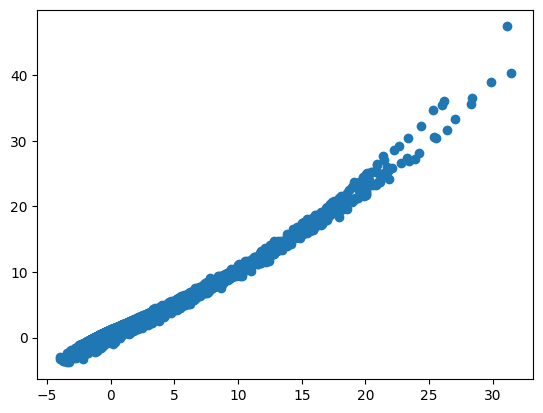

In [36]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [37]:
nwj_fun(y, t_x_pred)

1.9928017

In [38]:
nwj_fun(y, t_x_opt)

2.2327093606603903